I made lists of barcodes using the extractBCs method in another python notebook in this folder

Here I'm reloading the lists and generating a list of counts for each unique barcode in a single dataframe

I'm including the PacBio data, both raw and filtered



Still need:

Use Bokeh for all graphs

Subsample for coefficient of variation to see if it changes



In [1]:
import numpy as np
import itertools
import math
import pandas as pd
import time
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
import csv
import venn
from numpy import cov
from scipy.stats import spearmanr, pearsonr
from numpy import cov
from scipy.stats import spearmanr

experimentName = 'NP_11_27_selection_first'
listOfFileNames = ['NP_11_27_23', 'NP_11_27_24', 'NP_11_27_25']


In [1]:
# Running this cell will stop the jupyter notebook from opening a new tab if that starts happening

import bokeh.io
from bokeh.layouts import gridplot
from bokeh.io import show, export_svgs, export_png
from bokeh.transform import transform
from bokeh.plotting import ColumnDataSource, output_file, figure, show, save, output_notebook, reset_output
from bokeh.models import BasicTicker, ColorBar, ColumnDataSource, LinearColorMapper, LogColorMapper, PrintfTickFormatter, Whisker, Title, NumeralTickFormatter, Label, LabelSet, Text, HoverTool
reset_output()
output_notebook()

Loading BokehJS ...

In [3]:
combinedDF = pd.read_csv(experimentName + '.csv')


/Users/noamprywes/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,7,8,9,10,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
# Histogram of coefficient of variation data

coeffVarDataDF = combinedDF.dropna(subset = ['Coefficient_of_variation'])['Coefficient_of_variation'].unique()

def make_plot(title, hist, edges, bins):
    TOOLS="crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,hover"
    
    source = ColumnDataSource(data=dict(   
    top=hist, 
    bottom=[0]*bins[1:], 
    left=edges[:-1],
    right=edges[1:]
    ))

    TOOLTIPS = [
        ("Bin contents", "@top"),
        ('Edges', "@left to @right")
    ]
    
    p = figure(title=title, 
               tools=TOOLS, 
#                tooltips = TOOLTIPS, 
               background_fill_color=None)
    
    p.quad(source = source, top="top", bottom="bottom", left="left", right="right",
       fill_color="black", line_color="white", alpha=0.5)

    p.y_range.start = 0
    p.xaxis.axis_label = 'Coefficient of variation'
    p.yaxis.axis_label = 'Barcodes with that coefficient of variation'
    p.grid.grid_line_color="white"
    
    p.toolbar.logo = None
    
    # To get hover to work on iMac
    hover = HoverTool()
    hover.tooltips = TOOLTIPS
    p.tools.append(hover)
    
    # Shade in area where coeff. of var. <1
    p.quad(top=50, bottom=0, left=0, right=1, color='grey', alpha = 0.2)

    return p

bins = np.arange(0, 10, 0.1)
hist, edges = np.histogram(coeffVarDataDF, density=False, bins=bins, range = (0,10))

p1 = make_plot("Coefficient of variation distribution", hist, edges, bins)

label1 = Label(
                x=3.5, 
                y=50, 
                x_units='data', 
                y_units='data',
                text='Total mutants in sample: {}'.format(str(len(coeffVarDataDF))),
                text_font_size = '13px'
                )

label2 = Label(
                x=3.5, 
                y=45, 
                x_units='data', 
                y_units='data',
                text='Mutants with coefficient of variation under 1: {}'
                        .format(str(len(coeffVarDataDF[coeffVarDataDF < 1]))),
                text_font_size = '13px'
                )
                
p1.add_layout(label1)
p1.add_layout(label2)

p1.outline_line_color = None


# show(p1, ncols=1, plot_width=400, plot_height=400, toolbar_location=None)
show(p1)



In [5]:
# Generate data for barcode histograms

histData102 = []
histData103 = []
histData107 = []

for i, experiment in enumerate(listOfFileNames):
    data = np.histogram(combinedDF[str(listOfFileNames[i])], bins = range(0,100,1))
    histData102.append(data)
    data = np.histogram(combinedDF[str(listOfFileNames[i])], bins = range(0,1000,1))
    histData103.append(data)
    data = np.histogram(combinedDF[str(listOfFileNames[i])], bins = range(0,10000000,100000))
    histData107.append(data)


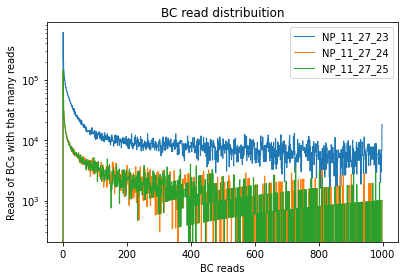

In [6]:
# This is a graph where I multiply by the number of barcodes again 
# The y-axis reads "reads of BCs with that many reads"
# I multiply each bin by its x-axis value
# I had to move the values over by one to handle indexes and I had to trim a value from the x-axis values
# Ideally, the total # of reads divided by the maximum of this curve will be the library complexity

for i, experiment in enumerate(listOfFileNames):
    xVals = histData103[0][1][1:]
    yVals = histData103[i][0]
    corrYVals = []
    for j, count in enumerate(yVals):
        corrYVals.append(count * (xVals[j] - 1))
    plt.step(xVals, corrYVals, label = listOfFileNames[i], linewidth = 1)
    
plt.title('BC read distribuition')
plt.ylabel('Reads of BCs with that many reads')
plt.xlabel('BC reads')
plt.tight_layout()
plt.rcParams["figure.figsize"] = (15,4)
plt.yscale("log")
plt.legend()

plt.savefig('NP_11_27_barcodesHist_selection.pdf')


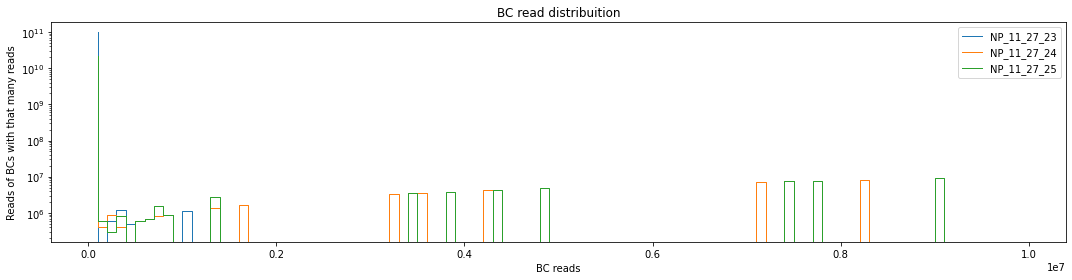

In [7]:
# Histogram out to many more reads

for i, experiment in enumerate(listOfFileNames):
    xVals = histData107[0][1][1:]
    yVals = histData107[i][0]
    corrYVals = []
    for j, count in enumerate(yVals):
        corrYVals.append(count * (xVals[j] - 1))
    plt.step(xVals, corrYVals, label = listOfFileNames[i], linewidth = 1)

plt.rcParams["figure.figsize"] = (15,4)
plt.yscale("log")
plt.title('BC read distribuition')
plt.ylabel('Reads of BCs with that many reads')
plt.xlabel('BC reads')
plt.yscale('log')
plt.tight_layout()
plt.legend()

plt.savefig('NP_11_27_barcodesHist_selection_107.pdf')

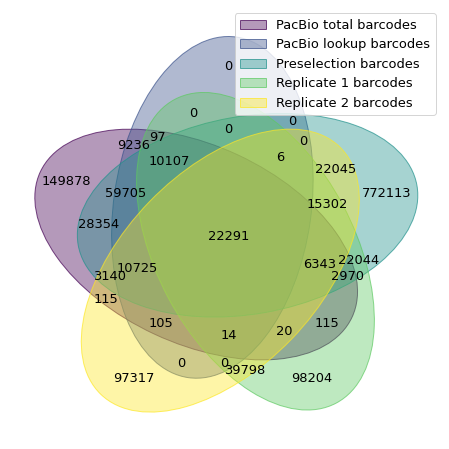

In [8]:
# lookup table (PacBio)
# Pre selection
# Rep1 and Rep2
# All PacBio barcodes, including those that didn't pass filters
# Use dropna() to pick barcodes that existed in each individual dataset

lookupBCs = set(combinedDF.dropna(subset=['correctedAAmut'])['Barcode'])
preselectionBCs = set(combinedDF.dropna(subset=['NP_11_27_23'])['Barcode'])
rep1BCs = set(combinedDF.dropna(subset=['NP_11_27_24'])['Barcode'])
rep2BCs = set(combinedDF.dropna(subset=['NP_11_27_25'])['Barcode'])
PacBioTotalBCs = set(combinedDF.dropna(subset=['Raw_PacBio_counts'])['Barcode'])

# Make venn diagram including unfiltered PacBio barcodes

from venn import venn
%matplotlib inline

BCData = {
    "PacBio total barcodes": PacBioTotalBCs, \
    "PacBio lookup barcodes": lookupBCs, \
    "Preselection barcodes": preselectionBCs, \
    "Replicate 1 barcodes": rep1BCs, \
    "Replicate 2 barcodes": rep2BCs
}

venn(BCData)

plt.savefig('NP-11-27-selection_venn.pdf')

